In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


##Imports

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 19 11:01:00 2021
PTM: all 3 sensors
stack both ankle and wrist as input
train a model for ankle+wrist, use trial1+trial2 data
acts: 0-'Lying', 1-'Sitting', 2-'Standing', 3-'TUG', 4-'Walking'
@author: hao_y
"""

#imports
import keras
from keras import layers, Sequential
from keras.layers import Input, Conv1D, Conv2D, Dense, Flatten,MaxPooling2D, concatenate,Permute,Reshape,LSTM, MultiHeadAttention, AdditiveAttention, Attention
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam 
import numpy as np
import glob
# from tools import convert_list, convert_y
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sn
from keras.models import model_from_json

from imblearn.over_sampling import SMOTE, RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Model Specifications

In [ ]:
NUM_CLASSES = 4

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 60

# Batch Size
BATCH_SIZE = 128

# Number filters convolutional layers
NUM_FILTERS = 64

# Size filters convolutional layers
FILTER_SIZE = 5

# Number of unit in the long short-term recurrent layers
NUM_UNITS_LSTM = 128

NUM_CHANNEL = 9

##Tools


In [ ]:
def convert_list(my_list):
    length = len(my_list)
    if length == 0:
        return
    res = my_list[0]
    for i in range(1, length):
        res = np.vstack((res, my_list[i]))
    return res

def convert_y(my_list):
    length = len(my_list)
    if length==0:
        return
    res = my_list[0]
    for i in range(1,length):
        res = np.concatenate((res,my_list[i]))
    return res

def find_subid(path):
    sub_id_1 = path[63]
    sub_id_2 = path[64]
    if sub_id_2 in ['0','1','2','3','4','5','6','7','8','9']:
        sub_id = sub_id_1 + sub_id_2
    else:
        sub_id = sub_id_1

    return sub_id

##Functions for Loading Data

####Loading All Combination of Sensors

In [ ]:
#helper functions

# to load the windowed data
def load_tensor(path, sensor):
    # Read the array from disk
    #new_data = np.loadtxt('./ActiveData/Sub'+str(name)+'_data.txt')
    new_data = np.loadtxt(path)
    
    #changing NUM_CHANNEL according to sensor combination type
    combination = ['WT', 'AW']
    single = ['A', 'W', 'T']
    if sensor in combination:
        NUM_CHANNEL = 6
    elif sensor in single:
        NUM_CHANNEL = 3
    else:
        NUM_CHANNEL = 9

    # Note that this returned a 2D array!
    # print(new_data.shape)
    
    # However, going back to 3D is easy if we know the 
    # original shape of the array
    if sensor == "All":
        pass
    elif sensor == "WT":
        new_data = new_data[:,:6]
    elif sensor == "AW":
        new_data = new_data[:,3:]
    elif sensor == 'A':
        new_data = new_data[:,6:]
    elif sensor == 'W':
        new_data = new_data[:,3:6]
    elif sensor == 'T':
        new_data = new_data[:,:3]

    new_data = new_data.reshape((-1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL))

    return new_data, NUM_CHANNEL

###Normal Loading

In [ ]:
def load_by_trial(trial_id, arg, sensor): 
    #arg can be either 'train' or 'test'
    path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/*_'+arg+'_data.txt'
    x_list = glob.glob(path)
    # path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/*_train_label.txt'
    # y_list = glob.glob(path)
    y_list = [i[0:-8]+'label.txt' for i in x_list]
    X,Y = [],[]
    for i in tqdm(range(len(x_list))):
        x, channels = load_tensor(x_list[i], sensor)
        y = np.loadtxt(y_list[i])
        X.append(x)
        Y.append(y)
    x_ = convert_list(X)
    y_ = convert_y(Y)
    idx = np.where(y_==4)
    y_[idx] = 3 
    return x_, y_, channels

### Load by Subject

In [ ]:
def load_by_subject(id, arg, trial_id, sensor):
    x_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/Sub'+str(id)+'_'+arg+'_data.txt'
    y_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/Sub'+str(id)+'_'+arg+'_label.txt'
    x_data, _ = load_tensor(x_path, sensor)
    y_data = np.loadtxt(y_path) 

    return x_data, y_data

In [ ]:
# subject1 = 12
# subject2 = 21

# sensor = "T"

import seaborn as sns
def get_plot_data(subject, sensor):

    

    #for subject1 
    # -------------------------------------------------------------------------------

    x1train1, y1 = load_by_subject(subject, 'train', 1, sensor)
    x1train2, y2 = load_by_subject(subject, 'train', 2, sensor)

    x1test1, Y1 = load_by_subject(subject, 'test', 1, sensor)
    x1test2, Y2 = load_by_subject(subject, 'test', 2, sensor)

    #for subject 2
    # -------------------------------------------------------------------------------

    # x2train1, y3 = load_by_subject(subject2, 'train', 2, sensor)
    # x2train2, y4 = load_by_subject(subject2, 'train', 2, sensor)

    # x2test1, Y3 = load_by_subject(subject2, 'test', 2, sensor)
    # x2test2, Y4 = load_by_subject(subject2, 'test', 2, sensor)

    # -------------------------------------------------------------------------------

    X_train1 = np.vstack((x1train1,x1train2))
    # X_train2 = np.vstack((x2train1,x2train2))

    y_train1 = np.concatenate((y1,y2))
    # y_train2 = np.concatenate((y3,y4))

    # print(X_train1.shape, "Xtrain1")
    # print(X_train2.shape, "Xtrain2")

    # -------------------------------------------------------------------------------

    X_test1 = np.vstack((x1test1,x1test2))
    # X_test2 = np.vstack((x2test1,x2test2))

    y_test1 = np.concatenate((Y1,Y2))
    # y_test2 = np.concatenate((Y3,Y4))

    # print(X_test1.shape, "Xtest1")
    # print(X_test2.shape, "Xtest2")

    # -------------------------------------------------------------------------------


    x1 = np.vstack((X_train1,X_test1))
    # x2 = np.vstack((X_train2,X_test2))

    y1 = np.concatenate((y_train1,y_test1))
    # y2 = np.concatenate((y_train2,y_test2))

    # print(y1.shape)
    # print(y2.shape)

    # idx1 = np.where(y1==3)
    # idx2 = np.where(y2==3)

    # print(x1.shape, "X1 before")
    # print(x2.shape, "X2 before")

    # x1_change = x1[idx1]
    # x2_change = x2[idx2]

    # print(x1_change.shape, "X1 mid")
    # print(x2_change.shape, "X2 mid")

    x1 = np.reshape(x1, (int(x1.shape[0])*60, 3))
    # x2 = np.reshape(x2, (int(x2.shape[0])*60, 3))


    # print(x1.shape, "X1 after")
    # print(x2.shape, "X2 after")
    return x1

In [ ]:
def get_plot_data_walking(subject, sensor):

    

    #for subject1 
    # -------------------------------------------------------------------------------

    x1train1, y1 = load_by_subject(subject, 'train', 1, sensor)
    x1train2, y2 = load_by_subject(subject, 'train', 2, sensor)

    x1test1, Y1 = load_by_subject(subject, 'test', 1, sensor)
    x1test2, Y2 = load_by_subject(subject, 'test', 2, sensor)

    #for subject 2
    # -------------------------------------------------------------------------------

    # x2train1, y3 = load_by_subject(subject2, 'train', 2, sensor)
    # x2train2, y4 = load_by_subject(subject2, 'train', 2, sensor)

    # x2test1, Y3 = load_by_subject(subject2, 'test', 2, sensor)
    # x2test2, Y4 = load_by_subject(subject2, 'test', 2, sensor)

    # -------------------------------------------------------------------------------

    X_train1 = np.vstack((x1train1,x1train2))
    # X_train2 = np.vstack((x2train1,x2train2))

    y_train1 = np.concatenate((y1,y2))
    # y_train2 = np.concatenate((y3,y4))

    # print(X_train1.shape, "Xtrain1")
    # print(X_train2.shape, "Xtrain2")

    # -------------------------------------------------------------------------------

    X_test1 = np.vstack((x1test1,x1test2))
    # X_test2 = np.vstack((x2test1,x2test2))

    y_test1 = np.concatenate((Y1,Y2))
    # y_test2 = np.concatenate((Y3,Y4))

    # print(X_test1.shape, "Xtest1")
    # print(X_test2.shape, "Xtest2")

    # -------------------------------------------------------------------------------


    x1 = np.vstack((X_train1,X_test1))
    # x2 = np.vstack((X_train2,X_test2))

    y1 = np.concatenate((y_train1,y_test1))
    # y2 = np.concatenate((y_train2,y_test2))

    # print(y1.shape)
    # print(y2.shape)

    idx1 = np.where(y1>=3)
    # idx2 = np.where(y2==3)

    # print(x1.shape, "X1 before")
    # print(x2.shape, "X2 before")

    x1_change = x1[idx1]
    # x2_change = x2[idx2]

    # print(x1_change.shape, "X1 mid")
    # print(x2_change.shape, "X2 mid")

    x1 = np.reshape(x1_change, (int(x1_change.shape[0])*60, 3))
    # x2 = np.reshape(x2, (int(x2.shape[0])*60, 3))


    # print(x1.shape, "X1 after")
    # print(x2.shape, "X2 after")
    return x1

In [ ]:
sensor = 'T'
data = []
for i in tqdm(range(0, 30)):
    if i==23:
        continue
    else:
        data.append(get_plot_data(i, sensor))


100%|██████████| 30/30 [02:01<00:00,  4.04s/it]


In [ ]:
sensor = 'T'
data_walking = []
for i in tqdm(range(0, 30)):
    if i==23:
        continue
    else:
        data_walking.append(get_plot_data_walking(i, sensor))

100%|██████████| 30/30 [03:54<00:00,  7.81s/it]


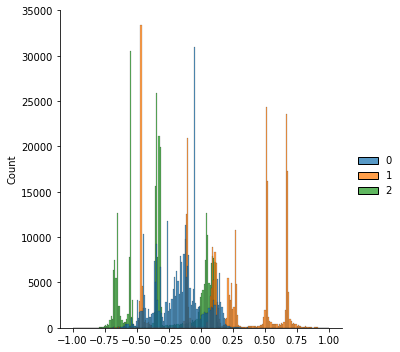

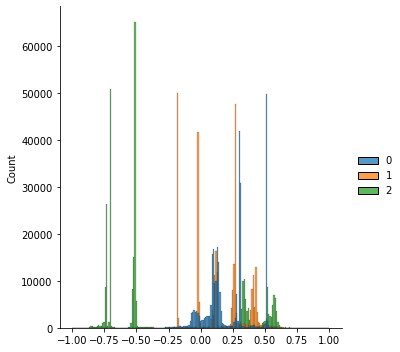

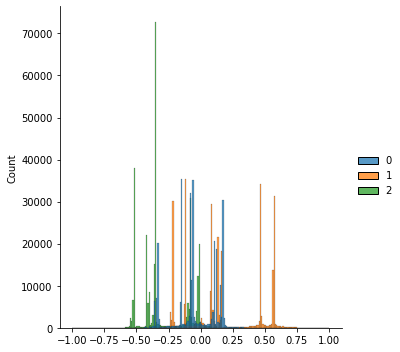

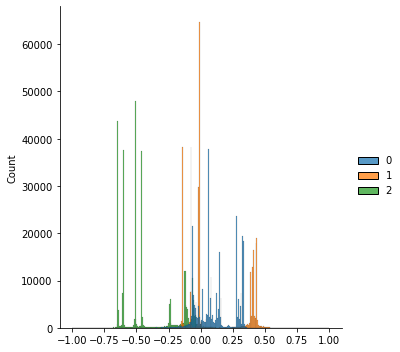

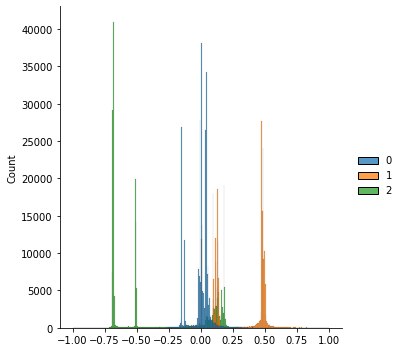

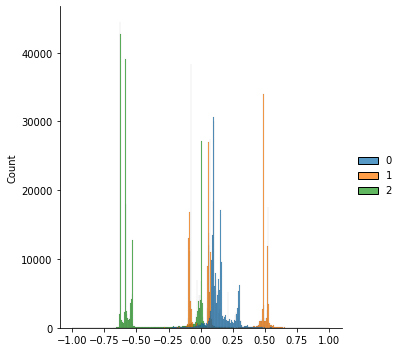

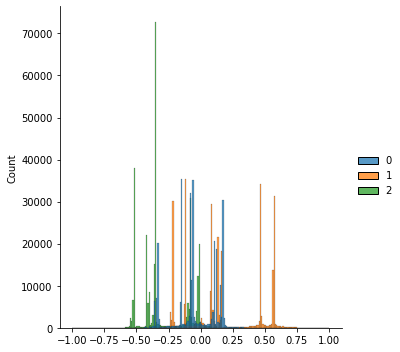

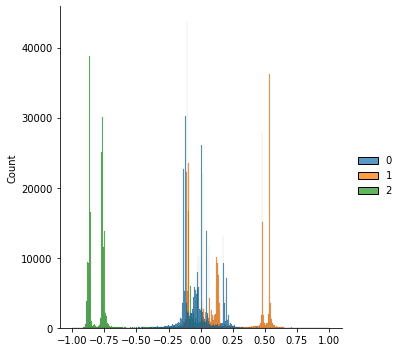

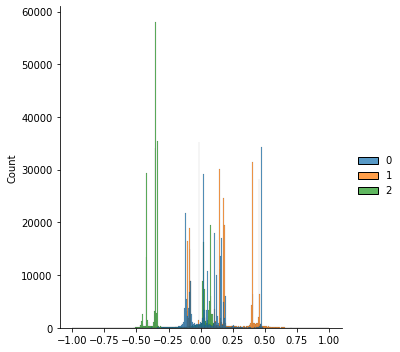

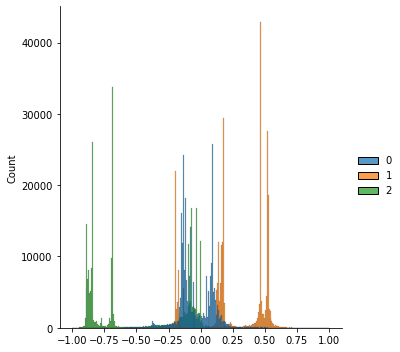

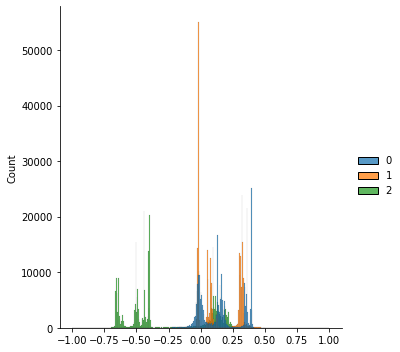

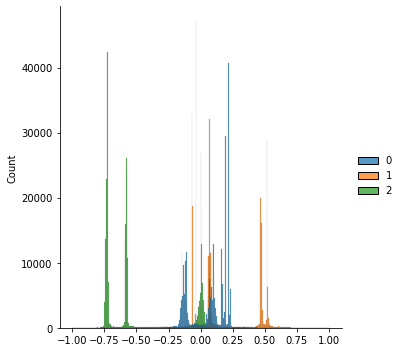

In [ ]:
subject_list = [12,11,10,4,5,8,10,20,6,9,21,24]
for i in subject_list:
    sns.displot(data[i])

In [ ]:
x1 = data_walking[11]
print(x1.shape)


(24120, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.array(df['x'])]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()


AttributeError: ignored

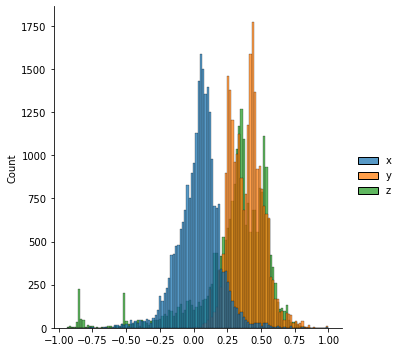

In [ ]:
df1 = pd.DataFrame(x1, columns = ['x','y','z'])
g = sns.displot(df1)
line = g.get_lines()[0]
xd = line.get_xdata()
yd = line.get_ydata()
def normalize(x):
    return (x - x.min(0)) / x.ptp(0)
#normalize points
yd2 = normalize(yd)
# plot them in another graph
plt.plot(x, y)
plt.xlabel('X input', fontsize=14)
plt.ylabel('Y output', fontsize=14)
ax2.set_title('basic distplot (kde=True)\nwith normalized y plot values')


plt.show()
g.set_axis_labels("Sensor Values", "Count")
g.set(ylim = [0,1])

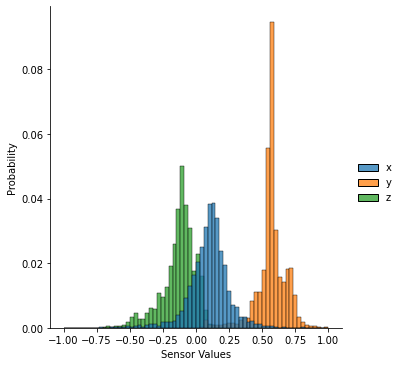

In [ ]:
x2 = data_walking[3]
df2 = pd.DataFrame(x2, columns = ['x','y','z'])
g = sns.displot(df2, stat='probability')
g.set_axis_labels("Sensor Values", "Probability")

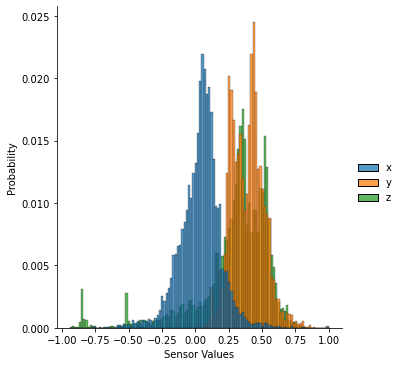

In [ ]:
x3 = data_walking[11]
df3 = pd.DataFrame(x3, columns = ['x','y','z'])
g = sns.displot(df3, stat='probability')
g.set_axis_labels("Sensor Values", "Probability")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


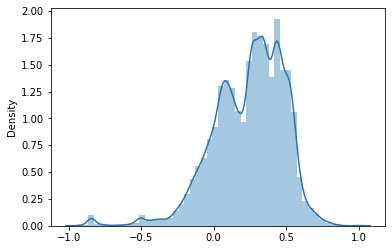

In [ ]:
x3 = data_walking[11]
df3 = pd.DataFrame(x3, columns = ['x','y','z'])
g = sns.distplot(df3, norm_hist=True)
# g.set_axis_labels("Sensor Values", "Count")

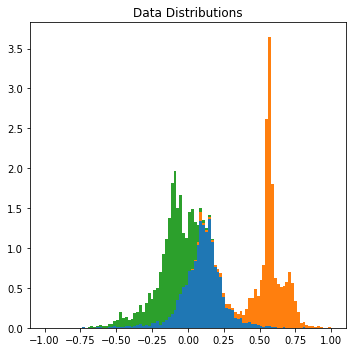

In [ ]:
n_bins = 100
fig, axes = plt.subplots(figsize=(5,5))
x_multi = [np.array(df2['x']), np.array(df2['y']), np.array(df2['z'])]
axes.hist(x_multi, n_bins, density='True',  histtype='stepfilled')
axes.set_title('Data Distributions')

fig.tight_layout()
plt.show()

In [ ]:
b,c = np.unique(np.array(df1['x']), return_counts=True)
print(np.sum(c))

24120


In [ ]:
import matplotlib
x2 = data_walking[3]
df2 = pd.DataFrame(x2, columns = ['x','y','z'])
a = matplotlib.colors.Normalize()
g = sns.displot(df2, kind='kde', hue_norm = a)
g.set_axis_labels("Sensor Values", "Count")

In [ ]:
def load_by_trial_unksub(trial_id, sensor, subject): 
    #pass the argument 'subject' as list of subjects to be used for testing
    #loads the passed subjects id from the test distribution and rest of the subjects from the train distribution
    #arg can be either 'train' or 'test'
    #both train and test are loaded here, can use the predict function directly
    train_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/*_train_data.txt'
    x_list = glob.glob(train_path)
    y_list = [i[0:-8]+'label.txt' for i in x_list]
    X_train,y_train, X_test, y_test = [],[],[],[]
    for i in tqdm(range(len(x_list))):
        sub_id = find_subid(x_list[i])
        if sub_id in subject:
            x_data, y_data = load_by_subject(sub_id, 'test', trial_id, sensor)
            X_test.append(x_data)
            y_test.append(y_data)
        else:
            x, channels = load_tensor(x_list[i], sensor)
            y = np.loadtxt(y_list[i])
            X_train.append(x)
            y_train.append(y)

    X_train = convert_list(X_train)
    X_test = convert_list(X_test)
    y_train = convert_y(y_train)
    y_test = convert_y(y_test)
    train_idx = np.where(y_train==4)
    test_idx = np.where(y_test==4)
    y_train[train_idx] = 3 
    y_test[test_idx] = 3
    return X_train, y_train, X_test, y_test, channels

###Loading Train Data - Normal

In [ ]:
# =============================================================================
# load data and train
# in the order of ['thigh','wrist','ankle']
# =============================================================================
sensor = 'All'
x1,y1,channels = load_by_trial(1, 'train', sensor)
x2,y2,channels = load_by_trial(2, 'train', sensor)

import collections

X_train = np.vstack((x1,x2))
y_train = np.concatenate((y1,y2))
print(collections.Counter(y_train))

from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
X_train = X_train.reshape(-1,SLIDING_WINDOW_LENGTH*channels)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(collections.Counter(y_train))
X_train = X_train.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)


labels = np.array([0,1,2,3])
lb = preprocessing.LabelBinarizer()
lb.fit(y=labels)

y_onehot_train = lb.transform(y_train) 
NUM_CHANNEL = channels

###Loading Train Data - Subject Based

In [ ]:
# =============================================================================
# load data and train
# in the order of ['thigh','wrist','ankle']
# =============================================================================
sensor = 'T'
testing_subjects = ['20']
xtrain1, ytrain1, xtest1, ytest1, channels = load_by_trial_unksub(1, sensor, subject = testing_subjects)
xtrain2, ytrain2, xtest2, ytest2, channels = load_by_trial_unksub(2, sensor, subject=testing_subjects)

import collections

X_train = np.vstack((xtrain1,xtrain2))
X_test = np.vstack((xtest1,xtest2))

y_train = np.concatenate((ytrain1,ytrain2))
y_test = np.concatenate((ytest1,ytest2))
print(collections.Counter(y_train))

from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
X_train = X_train.reshape(-1,SLIDING_WINDOW_LENGTH*channels)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(collections.Counter(y_train))
X_train = X_train.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)
X_test = X_test.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)


labels = np.array([0,1,2,3])
lb = preprocessing.LabelBinarizer()
lb.fit(y=labels)

y_onehot_train = lb.transform(y_train) 
# y_onehot_test = lb.transform(y_test)
NUM_CHANNEL = channels

In [ ]:
NUM_CHANNEL = channels

In [ ]:
print(X.shape, y_onehot.shape)

###Without Oversampling

In [ ]:
# X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels))
X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)

In [ ]:
print (X.shape, y_onehot.shape)

###Smote Oversampling

In [ ]:
##smote oversampling currently not used, instead use random oversampling

# orig_shape_x = X.shape
# orig_shape_y = y.shape

# X_inter = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
# print(X_inter.shape)

# oversample = SMOTE()
# X, y_onehot = oversample.fit_resample(X_inter, y_onehot)

# X = np.reshape(X, (-1, 60,9))

# X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL)

###For Transformer Based Models

In [ ]:
#run this cell for transformer based models

X_train = np.reshape(X_train, (-1, SLIDING_WINDOW_LENGTH,channels))

#transformer block takes in input in shape (batch_size, seq_len, embed_dim)
# X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL)

###Random Oversampling

In [ ]:
# orig_shape_x = X.shape
# orig_shape_y = y.shape

# X_inter = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
# print(X_inter.shape)

# oversample = RandomOverSampler()
# X, y_onehot = oversample.fit_resample(X_inter, y_onehot)

# X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels))

# X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL)

###For CPU

In [ ]:
X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels,1))

In [ ]:
print(X.shape)

###Saving Xtrain as a Numpy array


In [ ]:
# #####To avoid loading data everytime, instead load using np.load
# main_path = '/content/drive/MYDrive/MITACS_Nithin/juravinski/data/'
# xtrain_name = 'TransformertrainX'
# ytrain_name = 'TransformertrainY'
# np.save(main_path + xtrain_name, X)
# np.save(main_path + ytrain_name, y_onehot)

##Model Architecture

###Conv+LSTM

In [ ]:
def create_base_network(cpu=False):
    if cpu==True:
        multi_input = Input(shape=(SLIDING_WINDOW_LENGTH, NUM_CHANNEL,1), name='multi_input')
        format = 'channels_last'
    else:
        multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
        format = 'channels_first'
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(multi_input)
    print(y.shape)
    
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print(y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print(y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print(y.shape)
    y = Permute((2, 1, 3))(y)
    print(y.shape)
    # This line is what you missed
    # ==================================================================
    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)
    print(y.shape)
    # ==================================================================
    
    y = LSTM(128,dropout=0.25,return_sequences=True)(y)
    print(y.shape)
    y = LSTM(128)(y)
    print(y.shape)
    
    y = Dense(NUM_CLASSES,activation = 'softmax')(y)
    return Model(inputs=multi_input, outputs=y) 

###Conv+LSTM_Deeper


In [ ]:
def create_base_network_deeper(cpu=False):
    if cpu==True:
        multi_input = Input(shape=(SLIDING_WINDOW_LENGTH, NUM_CHANNEL,1), name='multi_input')
        format = 'channels_last'
    else:
        multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
        format = 'channels_first'
    print("1", multi_input.shape)  # (?, 1, 24, 113)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(multi_input)
    print("2",y.shape)  # (?, 64, 20, 113)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("3",y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("4",y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("5", y.shape)
    y = Conv2D(64, (5,1), activation='relu', data_format=format)(y)

    y = Conv2D(64, (5,1), activation='relu', data_format=format)(y)
    
    y = Permute((2, 1, 3))(y)
    print("6",y.shape)  # (?, 20, 64, 113)
    
    # This line is what you missed
    # ==================================================================
    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)

    # ==================================================================
    print("7",y.shape)  # (?, 20, 7232)
    
    y = LSTM(576,dropout=0.25,return_sequences=True)(y)
    print("8",y.shape)
    y = LSTM(256, return_sequences=True)(y)
    print("9",y.shape)
    y = LSTM(128, return_sequences=True)(y)
    print("10",y.shape)
    y = LSTM(128)(y)
    print("11",y.shape)
      # (?, 128)
    y = Dense(64,activation = 'relu')(y)
    print("12",y.shape)
    y = Dense(NUM_CLASSES, activation='softmax')(y)
    print("13",y.shape)
    return Model(inputs=multi_input, outputs=y) 

###Tensorflow Attention Code

In [ ]:
"""Attention layers that can be used in sequence DNN/CNN models.
This file follows the terminology of https://arxiv.org/abs/1706.03762 Figure 2.
Attention is formed by three tensors: Query, Key and Value.
"""

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.util.tf_export import keras_export

In [ ]:
class BaseDenseAttention(Layer):
  """Base Attention class for Dense networks.
  This class is suitable for Dense or CNN networks, and not for RNN networks.
  Implementations of attention mechanisms should inherit from this class, and
  reuse the `apply_attention_scores()` method.
  Args:
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
    dropout: Float between 0 and 1. Fraction of the units to drop for the
      attention scores.
  Call Args:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
    return_attention_scores: bool, it `True`, returns the attention scores
      (after masking and softmax) as an additional output argument.
  Output:
    Attention outputs of shape `[batch_size, Tq, dim]`.
    [Optional] Attention scores after masking and softmax with shape
      `[batch_size, Tq, Tv]`.
  """

  def __init__(self, causal=False, dropout=0.0,
               **kwargs):
    super(BaseDenseAttention, self).__init__(**kwargs)
    self.causal = causal
    self.dropout = dropout
    self.supports_masking = True

  def _calculate_scores(self, query, key):
    """Calculates attention scores.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    return NotImplementedError

  def _apply_scores(self, scores, value, scores_mask=None, training=None):
    """Applies attention scores to the given value tensor.
    To use this method in your attention layer, follow the steps:
    * Use `query` tensor of shape `[batch_size, Tq]` and `key` tensor of shape
      `[batch_size, Tv]` to calculate the attention `scores`.
    * Pass `scores` and `value` tensors to this method. The method applies
      `scores_mask`, calculates `attention_distribution = softmax(scores)`, then
      returns `matmul(attention_distribution, value).
    * Apply `query_mask` and return the result.
    Args:
      scores: Scores float tensor of shape `[batch_size, Tq, Tv]`.
      value: Value tensor of shape `[batch_size, Tv, dim]`.
      scores_mask: A boolean mask `Tensor` of shape `[batch_size, 1, Tv]` or
        `[batch_size, Tq, Tv]`. If given, scores at positions where
        `scores_mask==False` do not contribute to the result. It must contain
        at least one `True` value in each line along the last dimension.
      training: Python boolean indicating whether the layer should behave in
        training mode (adding dropout) or in inference mode (no dropout).
    Returns:
      Tensor of shape `[batch_size, Tq, dim]`.
      Attention scores after masking and softmax with shape
        `[batch_size, Tq, Tv]`.
    """
    if scores_mask is not None:
      padding_mask = math_ops.logical_not(scores_mask)
      # Bias so padding positions do not contribute to attention distribution.
      # Note 65504. is the max float16 value.
      if scores.dtype is dtypes.float16:
        scores -= 65504. * math_ops.cast(padding_mask, dtype=scores.dtype)
      else:
        scores -= 1.e9 * math_ops.cast(padding_mask, dtype=scores.dtype)
    if training is None:
      training = backend.learning_phase()
    weights = nn.softmax(scores)

    def dropped_weights():
      return nn.dropout(weights, rate=self.dropout)

    weights = control_flow_util.smart_cond(training, dropped_weights,
                                           lambda: array_ops.identity(weights))
    return math_ops.matmul(weights, value), weights

  # TODO(b/125916026): Consider exposing a __call__ method with named args.
  def call(self,
           inputs,
           mask=None,
           training=None,
           return_attention_scores=False):
    self._validate_call_args(inputs=inputs, mask=mask)
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v
    q_mask = mask[0] if mask else None
    v_mask = mask[1] if mask else None
    scores = self._calculate_scores(query=q, key=k)
    if v_mask is not None:
      # Mask of shape [batch_size, 1, Tv].
      v_mask = array_ops.expand_dims(v_mask, axis=-2)
    if self.causal:
      # Creates a lower triangular mask, so position i cannot attend to
      # positions j>i. This prevents the flow of information from the future
      # into the past.
      scores_shape = array_ops.shape(scores)
      # causal_mask_shape = [1, Tq, Tv].
      causal_mask_shape = array_ops.concat(
          [array_ops.ones_like(scores_shape[:-2]), scores_shape[-2:]],
          axis=0)
      causal_mask = _lower_triangular_mask(causal_mask_shape)
    else:
      causal_mask = None
    scores_mask = _merge_masks(v_mask, causal_mask)
    result, attention_scores = self._apply_scores(
        scores=scores, value=v, scores_mask=scores_mask, training=training)
    if q_mask is not None:
      # Mask of shape [batch_size, Tq, 1].
      q_mask = array_ops.expand_dims(q_mask, axis=-1)
      result *= math_ops.cast(q_mask, dtype=result.dtype)
    if return_attention_scores:
      return result, attention_scores
    return result

  def compute_mask(self, inputs, mask=None):
    self._validate_call_args(inputs=inputs, mask=mask)
    if mask:
      q_mask = mask[0]
      if q_mask is None:
        return None
      return ops.convert_to_tensor_v2_with_dispatch(q_mask)
    return None

  def _validate_call_args(self, inputs, mask):
    """Validates arguments of the call method."""
    class_name = self.__class__.__name__
    if not isinstance(inputs, list):
      raise ValueError(
          '{} layer must be called on a list of inputs, namely [query, value] '
          'or [query, value, key].'.format(class_name))
    if len(inputs) < 2 or len(inputs) > 3:
      raise ValueError(
          '{} layer accepts inputs list of length 2 or 3, '
          'namely [query, value] or [query, value, key]. '
          'Given length: {}'.format(class_name, len(inputs)))
    if mask:
      if not isinstance(mask, list):
        raise ValueError(
            '{} layer mask must be a list, '
            'namely [query_mask, value_mask].'.format(class_name))
      if len(mask) < 2 or len(mask) > len(inputs):
        raise ValueError(
            '{} layer mask must be a list of length 2, namely [query_mask, '
            'value_mask]. Given length: {}'.format(class_name, len(mask)))

  def get_config(self):
    config = {
        'causal': self.causal,
        'dropout': self.dropout,
    }
    base_config = super(BaseDenseAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:

@keras_export('keras.layers.Attention')
class Attention(BaseDenseAttention):
  """Dot-product attention layer, a.k.a. Luong-style attention.
  Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor of
  shape `[batch_size, Tv, dim]` and `key` tensor of shape
  `[batch_size, Tv, dim]`. The calculation follows the steps:
  1. Calculate scores with shape `[batch_size, Tq, Tv]` as a `query`-`key` dot
     product: `scores = tf.matmul(query, key, transpose_b=True)`.
  2. Use scores to calculate a distribution with shape
     `[batch_size, Tq, Tv]`: `distribution = tf.nn.softmax(scores)`.
  3. Use `distribution` to create a linear combination of `value` with
     shape `[batch_size, Tq, dim]`:
     `return tf.matmul(distribution, value)`.
  Args:
    use_scale: If `True`, will create a scalar variable to scale the attention
      scores.
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
    dropout: Float between 0 and 1. Fraction of the units to drop for the
      attention scores.
  Call Args:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
    return_attention_scores: bool, it `True`, returns the attention scores
      (after masking and softmax) as an additional output argument.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
  Output:
    Attention outputs of shape `[batch_size, Tq, dim]`.
    [Optional] Attention scores after masking and softmax with shape
      `[batch_size, Tq, Tv]`.
  The meaning of `query`, `value` and `key` depend on the application. In the
  case of text similarity, for example, `query` is the sequence embeddings of
  the first piece of text and `value` is the sequence embeddings of the second
  piece of text. `key` is usually the same tensor as `value`.
  Here is a code example for using `Attention` in a CNN+Attention network:
  ```python
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(None,), dtype='int32')
  value_input = tf.keras.Input(shape=(None,), dtype='int32')
  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(value_input)
  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)
  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.Attention()(
      [query_seq_encoding, value_seq_encoding])
  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)
  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  # Add DNN layers, and create Model.
  # ...
  ```
  """

  def __init__(self, use_scale=False, **kwargs):
    super(Attention, self).__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    """Creates scale variable if use_scale==True."""
    if self.use_scale:
      self.scale = self.add_weight(
          name='scale',
          shape=(),
          initializer=init_ops.ones_initializer(),
          dtype=self.dtype,
          trainable=True)
    else:
      self.scale = None
    super(Attention, self).build(input_shape)

  def _calculate_scores(self, query, key):
    """Calculates attention scores as a query-key dot product.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    scores = math_ops.matmul(query, key, transpose_b=True)
    if self.scale is not None:
      scores *= self.scale
    return scores

  def get_config(self):
    config = {'use_scale': self.use_scale}
    base_config = super(Attention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


In [ ]:
@keras_export('keras.layers.AdditiveAttention')
class AdditiveAttention(BaseDenseAttention):
  """Additive attention layer, a.k.a. Bahdanau-style attention.
  Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor of
  shape `[batch_size, Tv, dim]` and `key` tensor of shape
  `[batch_size, Tv, dim]`. The calculation follows the steps:
  1. Reshape `query` and `value` into shapes `[batch_size, Tq, 1, dim]`
     and `[batch_size, 1, Tv, dim]` respectively.
  2. Calculate scores with shape `[batch_size, Tq, Tv]` as a non-linear
     sum: `scores = tf.reduce_sum(tf.tanh(query + value), axis=-1)`
  3. Use scores to calculate a distribution with shape
     `[batch_size, Tq, Tv]`: `distribution = tf.nn.softmax(scores)`.
  4. Use `distribution` to create a linear combination of `value` with
     shape `[batch_size, Tq, dim]`:
     `return tf.matmul(distribution, value)`.
  Args:
    use_scale: If `True`, will create a variable to scale the attention scores.
    causal: Boolean. Set to `True` for decoder self-attention. Adds a mask such
      that position `i` cannot attend to positions `j > i`. This prevents the
      flow of information from the future towards the past.
    dropout: Float between 0 and 1. Fraction of the units to drop for the
      attention scores.
  Call Args:
    inputs: List of the following tensors:
      * query: Query `Tensor` of shape `[batch_size, Tq, dim]`.
      * value: Value `Tensor` of shape `[batch_size, Tv, dim]`.
      * key: Optional key `Tensor` of shape `[batch_size, Tv, dim]`. If not
        given, will use `value` for both `key` and `value`, which is the
        most common case.
    mask: List of the following tensors:
      * query_mask: A boolean mask `Tensor` of shape `[batch_size, Tq]`.
        If given, the output will be zero at the positions where
        `mask==False`.
      * value_mask: A boolean mask `Tensor` of shape `[batch_size, Tv]`.
        If given, will apply the mask such that values at positions where
        `mask==False` do not contribute to the result.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
    return_attention_scores: bool, it `True`, returns the attention scores
      (after masking and softmax) as an additional output argument.
  Output:
    Attention outputs of shape `[batch_size, Tq, dim]`.
    [Optional] Attention scores after masking and softmax with shape
      `[batch_size, Tq, Tv]`.
  The meaning of `query`, `value` and `key` depend on the application. In the
  case of text similarity, for example, `query` is the sequence embeddings of
  the first piece of text and `value` is the sequence embeddings of the second
  piece of text. `key` is usually the same tensor as `value`.
  Here is a code example for using `AdditiveAttention` in a CNN+Attention
  network:
  ```python
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(None,), dtype='int32')
  value_input = tf.keras.Input(shape=(None,), dtype='int32')
  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(max_tokens, dimension)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(value_input)
  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)
  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.AdditiveAttention()(
      [query_seq_encoding, value_seq_encoding])
  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)
  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  # Add DNN layers, and create Model.
  # ...
  ```
  """

  def __init__(self, use_scale=True, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    v_shape = tensor_shape.TensorShape(input_shape[1])
    dim = v_shape[-1]
    if isinstance(dim, tensor_shape.Dimension):
      dim = dim.value
    if self.use_scale:
      self.scale = self.add_weight(
          name='scale',
          shape=[dim],
          initializer=init_ops.glorot_uniform_initializer(),
          dtype=self.dtype,
          trainable=True)
    else:
      self.scale = None
    super(AdditiveAttention, self).build(input_shape)

  def _calculate_scores(self, query, key):
    """Calculates attention scores as a nonlinear sum of query and key.
    Args:
      query: Query tensor of shape `[batch_size, Tq, dim]`.
      key: Key tensor of shape `[batch_size, Tv, dim]`.
    Returns:
      Tensor of shape `[batch_size, Tq, Tv]`.
    """
    # Reshape tensors to enable broadcasting.
    # Reshape into [batch_size, Tq, 1, dim].
    q_reshaped = array_ops.expand_dims(query, axis=-2)
    # Reshape into [batch_size, 1, Tv, dim].
    k_reshaped = array_ops.expand_dims(key, axis=-3)
    if self.use_scale:
      scale = self.scale
    else:
      scale = 1.
    return math_ops.reduce_sum(
        scale * math_ops.tanh(q_reshaped + k_reshaped), axis=-1)

  def get_config(self):
    config = {'use_scale': self.use_scale}
    base_config = super(AdditiveAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


def _lower_triangular_mask(shape):
  """Creates a lower-triangular boolean mask over the last 2 dimensions."""
  row_index = math_ops.cumsum(
      array_ops.ones(shape=shape, dtype=dtypes.int32), axis=-2)
  col_index = math_ops.cumsum(
      array_ops.ones(shape=shape, dtype=dtypes.int32), axis=-1)
  return math_ops.greater_equal(row_index, col_index)


def _merge_masks(x, y):
  if x is None:
    return y
  if y is None:
    return x
  return math_ops.logical_and(x, y)

###Conv+Att+LSTM

In [ ]:
def Conv_Att_LSTM(cpu=False, attention = "Luong", dropout = 0.2):  #specify type of attention as a param
    if cpu==True:
        multi_input = Input(shape=(SLIDING_WINDOW_LENGTH, NUM_CHANNEL,1), name='multi_input')
        format = 'channels_last'
    else:
        multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
        format = 'channels_first'

    
    print("Input: ", multi_input.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(multi_input)
    print("1: ", y.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("2: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("3: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    print("4: ", y.shape)

    y = Permute((2, 1, 3))(y)
    print("5: ", y.shape)

    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)
    print("6: ", y.shape)

    #adding attention layer, type of attention specified above

    if attention == "Luong":
        attention1 = Attention(dropout = dropout)
        attention2 = Attention(dropout = dropout)
    # elif attention == 'MultiHead':
    #     attention1 = MultiHeadAttention(num_heads=4, key_dim = int(y.shape[2]))
    #     attention2 = MultiHeadAttention(num_heads=4, key_dim = int(y.shape[2]))

    query_encoding1 = Dense(300, activation = 'relu')(y)

    value_encoding1 = Dense(300, activation = 'relu')(y)

    # print("Query1", query1.shape)

    y = attention1([query_encoding1,value_encoding1]) #attention layer - more like self attention but used along with conv and lstm
    
    # print("attention1", y.shape)

    # print("Between", y.shape)
    
    y = LSTM(128,dropout=0.25,return_sequences=True)(y)

    # print("7: ", y.shape)

    query_encoding2 = Dense(int(y.shape[2]), activation = 'relu')(y)

    value_encoding2 = Dense(int(y.shape[2]), activation = 'relu')(y)

    # print("Query2", query2.shape)

    y = attention2([query_encoding2,value_encoding2])
    # print("attention2", y.shape)

    y = LSTM(128)(y)

    # y = attention([y,y])

    # print("8: ", y.shape)
    
    y = Dense(NUM_CLASSES,activation = 'softmax')(y)
    # print("9: ", y.shape)
    return Model(inputs=multi_input, outputs=y) 

In [ ]:
#params
embed_dim = 9
seq_size = 60
num_heads = 3
ff_dim = 27
dropout = 0.1
maxlen = 60

##Model Creation

In [ ]:
basemodel = create_base_network()
adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
basemodel.compile(loss='binary_crossentropy', optimizer=adam_optim,metrics=['accuracy'])

In [ ]:
bahdanau = Conv_Att_LSTM(attention="Bahdanau")
adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
bahdanau.compile(loss='binary_crossentropy', optimizer=adam_optim,metrics=['accuracy'])
bahdanau.summary()

In [ ]:
luong = Conv_Att_LSTM(attention="Luong")
adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
luong.compile(loss='binary_crossentropy', optimizer=adam_optim,metrics=['accuracy'])
luong.summary()

In [ ]:
multihead = Conv_Att_LSTM(attention="MultiHead")
adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
multihead.compile(loss='binary_crossentropy', optimizer=adam_optim,metrics=['accuracy'])

In [ ]:
deepermodel = create_base_network_deeper()
adam_optim = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
deepermodel.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])

In [ ]:
transformermodel = TransformerModel()
adam_optim = adam_optim = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
transformermodel.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])

In [ ]:
transformermodelwpe = TransformerModelwithPositionalEmbedding()
adam_optim = adam_optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
transformermodelwpe.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy'])

In [ ]:
convtransformer = conv_transformer_ffn()
adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
convtransformer.compile(loss='binary_crossentropy', optimizer=adam_optim,metrics=['accuracy'])

##Model Training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history1 = basemodel.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

In [ ]:
history2 = deepermodel.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=1,
      validation_split=0.2,
        #callbacks=[callback],
      shuffle=True)

In [ ]:
history3 = transformermodel.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

In [ ]:
history4 = transformermodelwpe.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

In [ ]:
history5 = bahdanau.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

In [ ]:
history6 = luong.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

In [ ]:
history7 = convtransformer.fit(X_train, y_onehot_train,
      batch_size=BATCH_SIZE,
      epochs=100,
      validation_split=0.2,
    #   callbacks=[callback],
      shuffle=True)

###Subject Wise Testing

In [ ]:
predy = basemodel.predict(X_test)
y_hat = lb.inverse_transform(predy)
acc = eval_perf(y_hat,y_test)

##Saving Model and Plotting

Saved model to disk


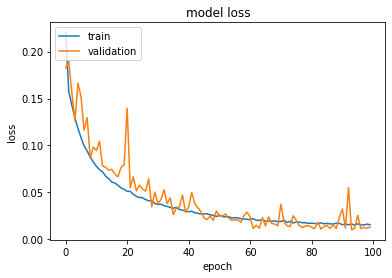

In [ ]:
# =============================================================================
# save training history plot and trained model
# =============================================================================
# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# plt.plot(history6.history['loss'])
# plt.plot(history6.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')

modelname1 = 'convlstm_second_random'
modelname2 = 'luong2_random'
plt.savefig('/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/all3_'+modelname1+'_retrained.png')

# serialize model to JSON
model_json = basemodel.to_json()
with open("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3_"+modelname1+"_retrained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
basemodel.save_weights("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3_"+modelname1+"_retrained.h5")
print("Saved model to disk")



# plt.savefig('/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/all3_'+modelname2+'_retrained.png')

# # serialize model to JSON
# model_json = luong.to_json()
# with open("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3_"+modelname2+"_retrained.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# luong.save_weights("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3_"+modelname2+"_retrained.h5")
# print("Saved model to disk")

# model2_json = model2.to_json()
# with open("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3sensorsdeeper.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_all3sensorsdeeper.h5")
# print("Saved model to disk")

##Evaluation

In [ ]:
def eval_perf(ground_truth, predicted_event):
    print('Accuracy score is: ')
    acc = accuracy_score(ground_truth, predicted_event)
    print(acc)
    print('Confusion Matrix is:')
    my_matrix = confusion_matrix(ground_truth, predicted_event)
    my_matrix_n = normalize(my_matrix, axis=1,norm = 'l1')
    print(pd.DataFrame(my_matrix_n).applymap(lambda x: '{:.2%}'.format(x)).values)

    #target_names = ['Walking','Jogging','Stairs','Sitting','Standing']
    target_names = ['Lying', 'Sitting', 'Standing', 'Walking']
    df_cm = pd.DataFrame(my_matrix_n, index = [i for i in target_names],
                  columns = [i for i in target_names])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    print(classification_report(ground_truth, predicted_event, target_names=target_names))  
    return acc

###Load Model

In [ ]:
sensorcomb = 'all3'
sensor1combination = 'anklewrist'
sensor2combination = 'wristthigh'
modelname = 'convlstm_second_random'

In [ ]:
sensor = "All"
SLIDING_WINDOW_LENGTH = 60
NUM_CHANNEL=9

In [ ]:
def load_model(sensor):
    # json_file = open('/content/drive/MyDrive/MITACS_Nithin_Nithin_Nithin_Nithin/juravinski/models_figs/4act_'+ sensorcomb + '_' + modelname + '_retrained.json', 'r')
    # loaded_model_json = json_file.read()
    # json_file.close()
    # model = model_from_json(loaded_model_json)
    model = create_base_network()
    # load weights into new model
    model.load_weights('/content/drive/MyDrive/MITACS_Nithin/juravinski/models_figs/4act_'+ sensorcomb + '_' + modelname +'_retrained.h5')
    print("Loaded model from disk")
    print(model.summary())
    return model

In [ ]:
model = load_model(sensor)

(None, 64, 56, 9)
(None, 64, 52, 9)
(None, 64, 48, 9)
(None, 64, 44, 9)
(None, 44, 64, 9)
(None, 44, 576)
(None, 44, 128)
(None, 128)
Loaded model from disk
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_input (InputLayer)     [(None, 1, 60, 9)]        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 56, 9)         384       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 52, 9)         20544     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 48, 9)         20544     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 44, 9)         20544     
_________________________________________________________________
permute_5 (Permute)          (None

###Loading Test Data

In [ ]:
x1,y1, channels = load_by_trial(1, 'test', 'All')
x2,y2, channels = load_by_trial(2, 'test', 'All')

X = np.vstack((x1,x2))
X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)
y = np.concatenate((y1,y2))

labels = np.array([0,1,2,3])
lb = preprocessing.LabelBinarizer()
lb.fit(y=labels)
# X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels,1))  #comment this line if running on GPU

100%|██████████| 29/29 [00:36<00:00,  1.26s/it]


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
# X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels,1))  #comment this line if running on GPU

In [ ]:
X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,channels)

In [ ]:
X = np.reshape(X, (-1, SLIDING_WINDOW_LENGTH,channels))

###Model Prediction

Accuracy score is: 
0.9813608067275839
Confusion Matrix is:
[['97.97%' '1.89%' '0.07%' '0.07%']
 ['0.68%' '98.03%' '1.09%' '0.20%']
 ['0.03%' '1.09%' '98.54%' '0.35%']
 ['0.14%' '0.58%' '1.45%' '97.83%']]
              precision    recall  f1-score   support

       Lying       0.99      0.98      0.99      8479
     Sitting       0.97      0.98      0.97      8425
    Standing       0.98      0.99      0.98      7804
     Walking       0.98      0.98      0.98      2761

    accuracy                           0.98     27469
   macro avg       0.98      0.98      0.98     27469
weighted avg       0.98      0.98      0.98     27469



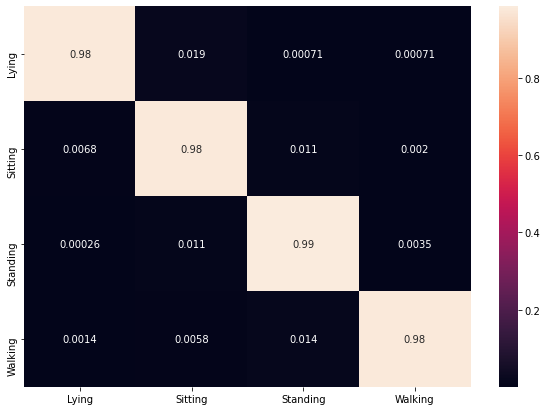

In [ ]:
predy = model.predict(X)
y_hat = lb.inverse_transform(predy)
acc = eval_perf(y_hat,y)

##Visualizing Data

NameError: ignored

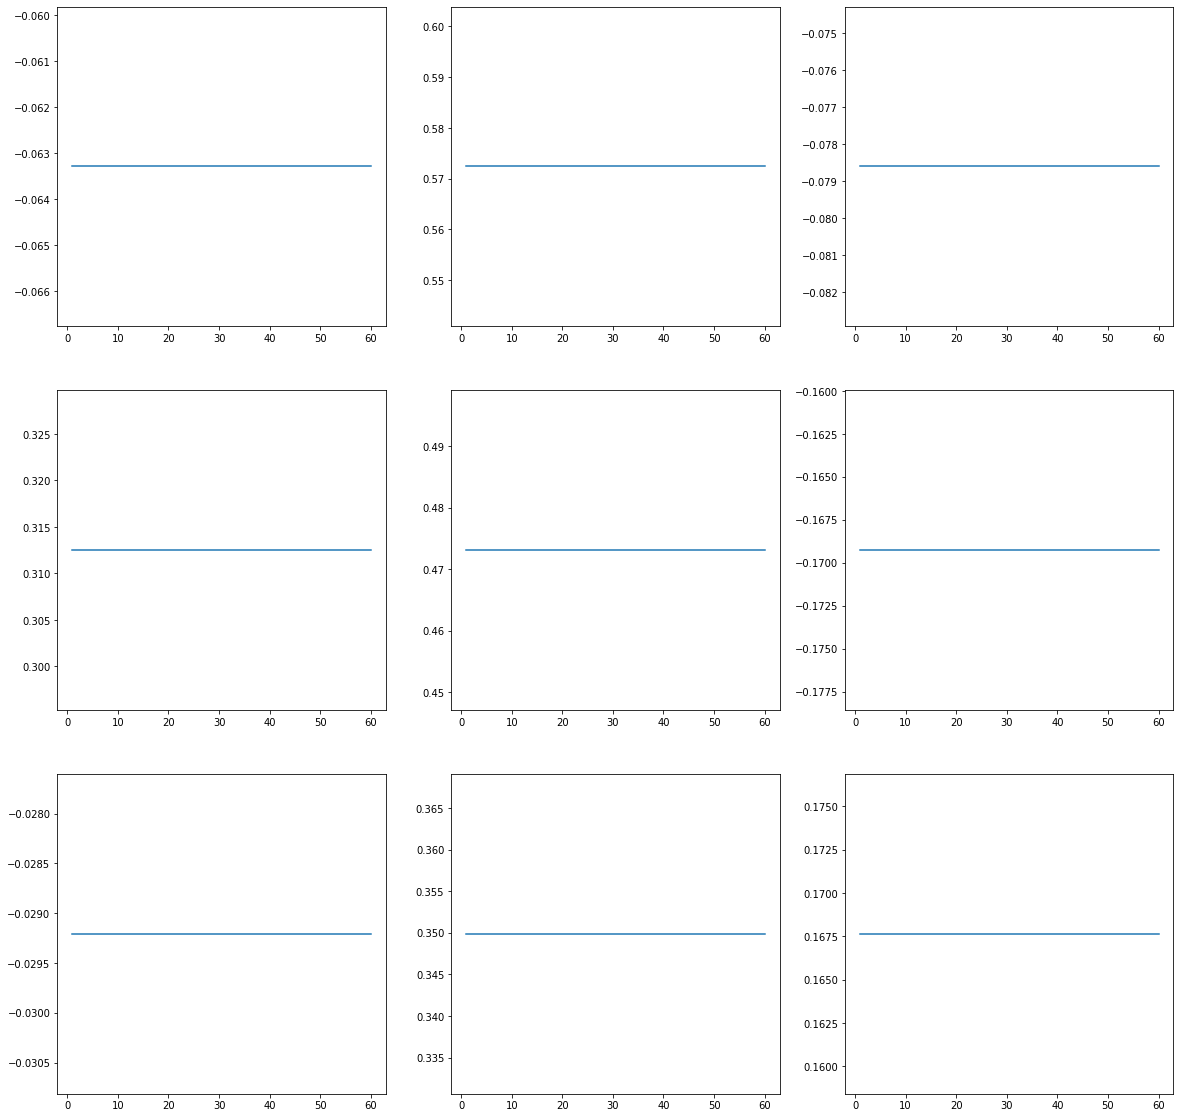

In [ ]:
X = np.load('/content/drive/MyDrive/MITACS_Nithin/juravinski/data/TransformertrainX.npy')
y_onehot = np.load('/content/drive/MyDrive/MITACS_Nithin/juravinski/data/TransformertrainY.npy')
fig = plt.figure(figsize=(20,20))
x = range(1,61)
idx=2
ax1 = fig.add_subplot(3,3,1)
yplot1 = X[idx, :, 0]
ax2 = fig.add_subplot(3,3,2)
yplot2 = X[idx, :, 1]
ax3 = fig.add_subplot(3,3,3)
yplot3 = X[idx, :, 2]
ax4 = fig.add_subplot(3,3,4)
yplot4 = X[idx, :, 3]
ax5 = fig.add_subplot(3,3,5)
yplot5 = X[idx, :, 4]
ax6 = fig.add_subplot(3,3,6)
yplot6 = X[idx, :, 5]
ax7 = fig.add_subplot(3,3,7)
yplot7 = X[idx, :, 6]
ax8 = fig.add_subplot(3,3,8)
yplot8 = X[idx, :, 7]
ax9 = fig.add_subplot(3,3,9)
yplot9 = X[idx, :, 8]


ax1.plot(x,yplot1)
ax2.plot(x,yplot2)
ax3.plot(x,yplot3)
ax4.plot(x,yplot4)
ax5.plot(x,yplot5)
ax6.plot(x,yplot6)
ax7.plot(x,yplot7)
ax8.plot(x,yplot8)
ax9.plot(x,yplot9)

# print(yplot)
print(y[idx])
# print(y_onehot[idx])

In [ ]:
import collections
x1,y1 = load_by_trial(1)
x2,y2 = load_by_trial(2)

X = np.vstack((x1,x2))
y = np.concatenate((y1,y2))
print(collections.Counter(y))

from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
X = X.reshape(-1,SLIDING_WINDOW_LENGTH*NUM_CHANNEL)
X, y = oversample.fit_resample(X, y)
print(collections.Counter(y))
X = X.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL)


labels = np.array([0,1,2,3])
lb = preprocessing.LabelBinarizer()
lb.fit(y=labels)

y_onehot = lb.transform(y) 